In [4]:
!pip uninstall opencv-contrib-python -y
!pip uninstall opencv-python -y
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86


You can safely remove it manually.


Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl (46.2 MB)


In [5]:
# Imported Libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
import warnings
warnings.filterwarnings("ignore")

from utils.visualization import visualize_detections, print_detections
from utils.matchers import find_matcher_matrix
from utils.bbox_filtering import find_bboxes

# Images Path
scene_folder = './images/scenes/'
model_folder = './images/models/'
video_folder = './images/videos/'

#reloads external modules when they are changed
%load_ext autoreload
%autoreload 2

[autoreload of cv2.gapi failed: Traceback (most recent call last):
  File "C:\Users\lha15\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\lha15\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "d:\Games\anaconda\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "C:\Users\lha15\AppData\Roaming\Python\Python312\site-packages\cv2\gapi\__init__.py", line 323, in <module>
    cv.gapi.wip.GStreamerPipeline = cv.gapi_wip_gst_GStreamerPipeline
    ^^^^^^^^^^^
AttributeError: module 'cv2.gapi' has no attribute 'wip'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Lists with the scenes and models of Step B
valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
model_filenames = [f for f in os.listdir(model_folder) if f.lower().endswith(valid_extensions)]
scene_filenames = ['e4.png']

# Read images
im_scene_list_original = [cv2.cvtColor(cv2.imread(scene_folder + name), cv2.COLOR_BGR2RGB) for name in scene_filenames]
im_model_list_original = [cv2.cvtColor(cv2.imread(model_folder + name), cv2.COLOR_BGR2RGB) for name in model_filenames]

In [7]:
im_model_list = []
model_labels = []

for im, label in zip(im_model_list_original, model_filenames):
    aspect = im.shape[0]/im.shape[1]
    #resize model images
    for s in (360,):
        im_resized = cv2.resize(im, (s, int(s*aspect)))
        im_model_list.append(im_resized)
        model_labels.append(label)

    #gaussian blur on original images
    for sigma in (1.5, 3, 5):
        k = int(np.ceil(3*sigma))
        im_model_list.append(cv2.GaussianBlur(im, (2*k+1, 2*k+1), sigma))
        model_labels.append(label)

In [8]:
model_names = {}
for name in listdir(model_folder):
    simplified_name = name.rsplit('_', 1)[-1].split('.')[0]
    model_names[name] = simplified_name

In [9]:


### Initialization of Super Resolution 
train_dict = {1: ['fsrcnn', './weights/FSRCNN-small_x4.pb'],
              2: ['espcn', './weights/ESPCN_x4.pb'],
              3: ['edsr', './weights/EDSR_x4.pb'],
              4: ['lapsrn', './weights/LapSRN_x4.pb']}
nn_used = 4

sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel(train_dict[nn_used][1])
sr.setModel(train_dict[nn_used][0], 4)

# upsample scene images
im_scene_list = [sr.upsample(im) for im in im_scene_list_original]
#im_scene_list = im_scene_list_original

#save preprocessed images
#new_scene_folder = f"images/results/upscaled_scenes/upscaled_{nn_used}/"
#for im_scene, filename in zip(im_scene_list, scene_filenames):
#    cv2.imwrite(new_scene_folder + filename, cv2.cvtColor(im_scene, cv2.COLOR_RGB2BGR))



In [10]:
#set the ransac reprojection threshold when computing the homography
homography_kw = dict(match_distance_threshold = 0.88, ransacReprojThreshold = 1.)
peaks_kw = dict(height = 0.3, distance = 0)

#compute matcher matrix
matcher_matrix = find_matcher_matrix(im_scene_list, im_model_list, K=15, peaks_kw=peaks_kw, homography_kw=homography_kw)

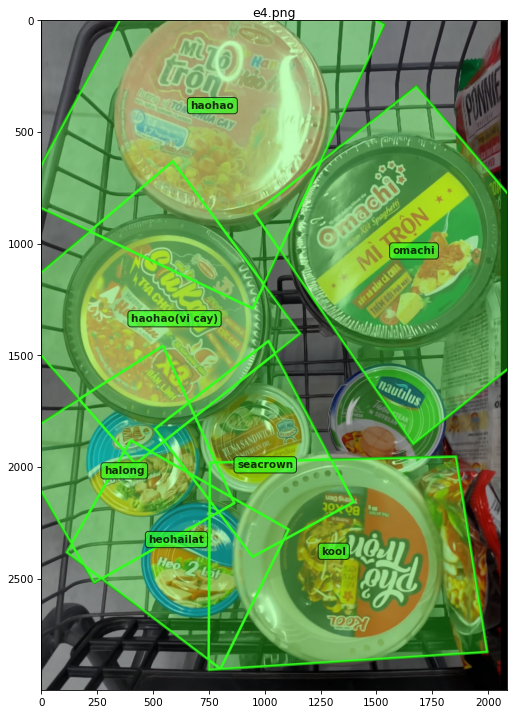

	Product halong - 1 instance found:
		Instance 1: (position: (380, 2031), width: 761px, height: 752px)
	Product haohao - 1 instance found:
		Instance 1: (position: (767, 396), width: 1096px, height: 1414px)
	Product haohao(vi cay) - 1 instance found:
		Instance 1: (position: (501, 1350), width: 943px, height: 978px)
	Product heohailat - 1 instance found:
		Instance 1: (position: (579, 2338), width: 837px, height: 636px)
	Product kool - 1 instance found:
		Instance 1: (position: (1353, 2391), width: 1175px, height: 907px)
	Product omachi - 1 instance found:
		Instance 1: (position: (1673, 1047), width: 985px, height: 1250px)
	Product seacrown - 1 instance found:
		Instance 1: (position: (976, 2004), width: 578px, height: 767px)


In [11]:
new_labels = [model_names[l] for l in model_labels]

for i in range(len(im_scene_list)):
    scene_name = scene_filenames[i]

    color_threshold = 15
    overlap_threshold = 0.5
    bbox_props = find_bboxes(matcher_matrix[i], new_labels, color_distance_threshold=color_threshold, min_match_threshold=6, bbox_overlap_threshold=overlap_threshold)

    w, h, dpi = 960, 720, 75
    fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)
    
    visualize_detections(im_scene_list[i], bbox_props, annotation_offset=100, ax=ax, draw_invalid_bbox=(0))
    fig.suptitle(scene_name)
    fig.tight_layout(pad=0.5)
    #fig.savefig('images/results/found_' + scene_name)
    plt.show()
    
    print_detections(bbox_props)

In [12]:
print("bbox_props:", bbox_props)

bbox_props: [{'model': 'haohao(vi cay)', 'corners': array([[[ 588.7041 ,  640.9667 ]],

       [[-191.91429, 1284.905  ]],

       [[ 422.95007, 1989.7552 ]],

       [[1154.313  , 1409.0852 ]]], dtype=float32), 'center': array([ 501.5375, 1350.7113], dtype=float32), 'match_number': 208, 'sufficient_matches': True, 'valid_shape': True, 'color_distance': 0.9504000340256363, 'valid_color': True, 'valid_bbox': False}, {'model': 'haohao(vi cay)', 'corners': array([[[ 593.9904 ,  630.16547]],

       [[-181.32158, 1288.4371 ]],

       [[ 419.04257, 1979.7985 ]],

       [[1165.0706 , 1409.1931 ]]], dtype=float32), 'center': array([ 500.55014, 1351.4315 ], dtype=float32), 'match_number': 1088, 'sufficient_matches': True, 'valid_shape': True, 'color_distance': 1.0090360869748076, 'valid_color': True, 'valid_bbox': False}, {'model': 'haohao(vi cay)', 'corners': array([[[ 590.49274,  623.4727 ]],

       [[-200.13521, 1283.3994 ]],

       [[ 422.48608, 1982.8812 ]],

       [[1153.7153 , 1412